In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys

## Prerequisites
- Set the root directory, and the results filename.
- Load the results into a DataFrame using `pandas`.
- Split the DataFrame into separate DataFrames for initial contacts and final contacts.

In [2]:
ROOT_DIR = ".."
results_filename = "results_v3.tsv"

In [3]:
df = pd.read_csv(os.path.join(ROOT_DIR, results_filename), header=0, sep="\t")
df.tail()

,sub_id,gender,age,participant_type,task,run,tracked_point,event_type,ix_ref,ix_pred,diff_samples,diff_msec,event_true,event_predicted,TP,FN,FP,check
6022,pp126,F,41,MS,Fast,NaN,left_ankle,IC,182.0,177.0,5.0,25.0,1,1,1,0,0,1
6023,pp126,F,41,MS,Fast,NaN,left_ankle,IC,425.0,426.0,-1.0,-5.0,1,1,1,0,0,1
6024,pp126,F,41,MS,Fast,NaN,left_ankle,IC,654.0,655.0,-1.0,-5.0,1,1,1,0,0,1
6025,pp126,F,41,MS,Fast,NaN,left_ankle,IC,877.0,876.0,1.0,5.0,1,1,1,0,0,1
6026,pp126,F,41,MS,Fast,NaN,left_ankle,FC,74.0,74.0,0.0,0.0,1,1,1,0,0,1


In [4]:
# Split for events
df_ic = df.loc[df["event_type"]=="IC"]
df_fc = df.loc[df["event_type"]=="FC"]

## Time agreement
For the correctly detected gait events, we quantify the time error:
$$\textrm{time error} = t_{\mathrm{ref}} - t_{\mathrm{pred}}$$
with $t_{\mathrm{ref}}$ the gait event time from the marker-based annotations, and $t_{\mathrm{pred}}$ the gait event time from the model predictions.


In [5]:
# Set the orde for plotting figures
tracked_points = ["left_ankle", "right_ankle", "left_shank", "right_shank"]
# tracked_points = df["tracked_point"].unique()
print(tracked_points)

['left_ankle', 'right_ankle', 'left_shank', 'right_shank']


First, visualize the time differences for each of the tracked points, to get an idea of the distributions.

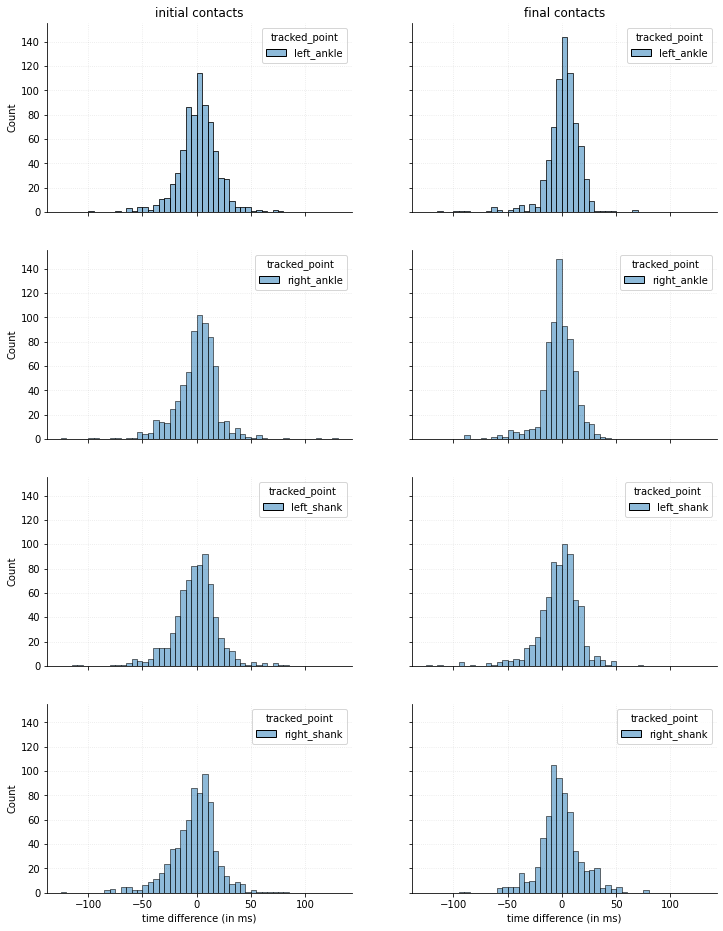

In [6]:
# Visualize distribution of time differences
fig, axs = plt.subplots(len(tracked_points), 2, figsize=([12.0, 16.0]), sharex=True, sharey=True)
for i, tracked_point in enumerate(tracked_points):
    sns.histplot(data=df_ic.loc[df_ic["tracked_point"]==tracked_point], x="diff_msec", binwidth=5, hue="tracked_point", ax=axs[i][0])
    sns.histplot(data=df_fc.loc[df_fc["tracked_point"]==tracked_point], x="diff_msec", binwidth=5, hue="tracked_point", ax=axs[i][1])
    axs[i][0].grid(which="major", c=(0, 0, 0), alpha=0.1, ls=":")
    axs[i][0].spines["top"].set_visible(False)
    axs[i][0].spines["right"].set_visible(False)
    axs[i][1].grid(which="major", c=(0, 0, 0), alpha=0.1, ls=":")
    axs[i][1].spines["top"].set_visible(False)
    axs[i][1].spines["right"].set_visible(False)
axs[0][0].set_title("initial contacts")
axs[0][1].set_title("final contacts")
axs[len(tracked_points)-1][0].set_xlabel("time difference (in ms)")
axs[len(tracked_points)-1][1].set_xlabel("time difference (in ms)")
plt.show()

Statistically evaluate the time error using the non-parametric Wilcoxon signed-rank test for non-normally distributed data.

In [7]:
from scipy.stats import normaltest, wilcoxon, kstest

In [8]:
df_ic_clean = df_ic.dropna(
        axis=0,                # drop rows that contain NA values
        subset=["diff_msec"],  # based on column `diff_msec`
        inplace=False          # but don't do it inplace
)
df_fc_clean = df_fc.dropna(
        axis=0,                # drop rows that contain NA values
        subset=["diff_msec"],  # based on column `diff_msec`
        inplace=False          # but don't do it inplace
)

In [10]:
alpha = 0.05
for _, tracked_point in enumerate(tracked_points):
    data = df_ic_clean.loc[df_ic_clean["tracked_point"]==tracked_point]["diff_msec"].values[:]
    statistic, pvalue = kstest(data, "norm")
    if pvalue < alpha:
        print("Reject the null hypothesis. Data do not come from a normal distribution.")
        statistic, pvalue = wilcoxon(data)
        print(f"... {tracked_point:s}, {statistic:.3f}, {pvalue:.6f}")
    

Reject the null hypothesis. Data do not come from a normal distribution.
... left_ankle, 87655.000, 0.158650
Reject the null hypothesis. Data do not come from a normal distribution.
... right_ankle, 81990.500, 0.023783
Reject the null hypothesis. Data do not come from a normal distribution.
... left_shank, 74235.500, 0.000000
Reject the null hypothesis. Data do not come from a normal distribution.
... right_shank, 75011.000, 0.000000


In [11]:
alpha = 0.05
for _, tracked_point in enumerate(tracked_points):
    data = df_fc_clean.loc[df_fc_clean["tracked_point"]==tracked_point]["diff_msec"].values[:]
    statistic, pvalue = kstest(data, "norm")
    if pvalue < alpha:
        print("Reject the null hypothesis. Data do not come from a normal distribution.")
        statistic, pvalue = wilcoxon(data)
        print(f"... {tracked_point:s}, {statistic:.3f}, {pvalue:.06f}")

Reject the null hypothesis. Data do not come from a normal distribution.
... left_ankle, 77931.000, 0.599621
Reject the null hypothesis. Data do not come from a normal distribution.
... right_ankle, 56819.000, 0.000000
Reject the null hypothesis. Data do not come from a normal distribution.
... left_shank, 59384.500, 0.000000
Reject the null hypothesis. Data do not come from a normal distribution.
... right_shank, 59953.500, 0.000000


In [12]:
from scipy.stats import norm
for _, tracked_point in enumerate(tracked_points):
    data = df_ic_clean.loc[df_ic_clean["tracked_point"]==tracked_point]["diff_msec"].values[:]
    x_bar = np.mean(data)
    sd = np.std(data)
    n = len(data)
    low = x_bar - norm.ppf(0.975) * sd / np.sqrt(n)
    high = x_bar + norm.ppf(0.975) * sd / np.sqrt(n)
    print(f"{tracked_point:>12s}: {x_bar:>.1f} {low:>.1f} {high:>.1f}")

  left_ankle: -1.1 -2.5 0.2
 right_ankle: -2.3 -3.8 -0.7
  left_shank: -4.0 -5.5 -2.5
 right_shank: -4.8 -6.4 -3.2


In [13]:
from scipy.stats import norm
for _, tracked_point in enumerate(tracked_points):
    data = df_fc_clean.loc[df_fc_clean["tracked_point"]==tracked_point]["diff_msec"].values[:]
    x_bar = np.mean(data)
    sd = np.std(data)
    n = len(data)
    low = x_bar - norm.ppf(0.975) * sd / np.sqrt(n)
    high = x_bar + norm.ppf(0.975) * sd / np.sqrt(n)
    print(f"{tracked_point:>12s}: {x_bar:>.1f} {low:>.1f} {high:>.1f}")

  left_ankle: -1.3 -2.5 -0.1
 right_ankle: -5.3 -6.5 -4.2
  left_shank: -5.4 -6.8 -3.9
 right_shank: -4.3 -5.8 -2.8


/tmp/ipykernel_14743/1781564725.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(np.arange(-150, 200, 50), fontsize=16)


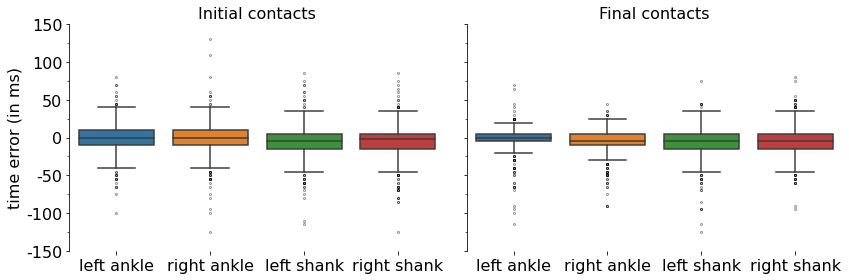

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12.0, 4.0), sharey=True)
sns.boxplot(data=df_ic_clean, x="tracked_point", y="diff_msec", order=tracked_points, flierprops=dict(marker='o', ms=2, mec=(0, 0, 0), alpha=0.4, mfc='none'), ax=axs[0])
sns.boxplot(data=df_fc_clean, x="tracked_point", y="diff_msec", order=tracked_points, flierprops=dict(marker='o', ms=2, mec=(0, 0, 0), alpha=0.4, mfc='none'), ax=axs[1])
axs[0].set_xlabel("")
axs[0].set_xticklabels(["left ankle", "right ankle", "left shank", "right shank"], fontsize=16)
axs[0].set_ylim([-150, 150])
axs[0].yaxis.set_minor_locator(plt.MultipleLocator(25))
axs[0].set_yticklabels(np.arange(-150, 200, 50), fontsize=16)
axs[1].set_xlabel("")
axs[1].set_xticklabels(["left ankle", "right ankle", "left shank", "right shank"], fontsize=16)
axs[0].set_ylabel("time error (in ms)", fontsize=16)

axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].set_title("Initial contacts", fontsize=16)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_visible(False)
axs[1].set_ylabel("")
axs[1].set_title("Final contacts", fontsize=16)
plt.tight_layout()
plt.savefig("D:\\Projects\\my-gait-events-tcn\\paper\\MDPI_template\\fig\\box_plots_tracked_points_with_outliers.png", dpi=300)
plt.show()